In [54]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

In [ ]:
# Configuration
TEST_START = '2025-01-01'
TEST_END = '2025-07-01'

# Markowitz hyperparameters
lookback_months = 12
rebalance_freq = 'D'  # 'D','B','W','W-FRI','ME','MS','QE','QS','A','AS'

rf_annual = 0.04
rf_daily = rf_annual / 252

output_dir = "markowitz_outputs"
os.makedirs(output_dir, exist_ok=True)

In [56]:
# Our chosen list of ETFs

etfs = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'VNQ', 'TLT', 'IEF', 'GLD', 'USO']

# Load adjusted prices from EODHD-based CSV (2014 to today)
adj_close_prices = pd.read_csv("../data/etf_prices.csv", index_col=0, parse_dates=True)[etfs]
# Use full history from 2014 onward
adj_close_prices = adj_close_prices.loc['2014-01-01':]

# We'll use all data from 2014 onward for rolling Markowitz

In [57]:
# Rolling Markowitz Portfolio - Clean Implementation

# Use full historical returns for lookback calculations
returns_full = adj_close_prices.pct_change().dropna()

# Get test period trading dates
test_dates = adj_close_prices.loc[TEST_START:TEST_END].index
if len(test_dates) == 0:
    raise ValueError("No trading days in test period.")

# Generate rebalance dates within test period based on frequency
def get_rebalance_dates(dates, freq):
    if freq in ['D', 'B']:
        return dates
    else:
        # Generate frequency anchors and map to actual trading days
        anchors = pd.date_range(start=dates[0], end=dates[-1], freq=freq)
        rebalance_dates = []
        for anchor in anchors:
            # Find closest trading day
            closest_idx = dates.get_indexer([anchor], method='nearest')[0]
            if closest_idx >= 0:
                rebalance_dates.append(dates[closest_idx])
        return pd.DatetimeIndex(sorted(set(rebalance_dates)))

rebalance_dates = get_rebalance_dates(test_dates, rebalance_freq)
print(f"Number of rebalance dates: {len(rebalance_dates)}")

# Calculate optimal weights for each rebalance date
weights_dict = {}
asset_list = adj_close_prices.columns.tolist()

for date in rebalance_dates:
    # Use lookback window ending BEFORE the rebalance date (no lookahead)
    lookback_start = date - pd.DateOffset(months=lookback_months)
    lookback_end = date - pd.Timedelta(days=1)
    
    # Get returns for lookback window from full history
    window_returns = returns_full.loc[lookback_start:lookback_end, asset_list]
    
    # Skip if insufficient data (need at least 20 observations)
    if len(window_returns) < 20:
        continue
    
    # Calculate mean returns and covariance matrix
    mean_returns = window_returns.mean()
    cov_matrix = window_returns.cov()
    
    # Optimize for maximum Sharpe ratio
    n_assets = len(asset_list)
    initial_weights = np.ones(n_assets) / n_assets
    bounds = tuple((0, 1) for _ in range(n_assets))
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    
    def negative_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        if portfolio_vol == 0:
            return 0
        return -(portfolio_return / portfolio_vol)
    
    result = minimize(negative_sharpe, initial_weights, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    if result.success:
        weights_dict[date] = result.x
    else:
        weights_dict[date] = initial_weights

print(f"Successfully calculated weights for {len(weights_dict)} dates")

# Create weights dataframe for all test dates
weights_df = pd.DataFrame(index=test_dates, columns=asset_list, dtype=float)

# Apply weights and forward fill
for date, weights in weights_dict.items():
    weights_df.loc[date] = weights

# Forward fill weights and handle any missing values at start
weights_df = weights_df.ffill()
if weights_df.iloc[0].isna().any():
    # If first day has NaN, use equal weights
    equal_weights = np.ones(len(asset_list)) / len(asset_list)
    weights_df.iloc[0] = equal_weights
    weights_df = weights_df.ffill()

# Calculate portfolio returns using test period returns
test_returns = returns_full.loc[test_dates, asset_list].fillna(0.0)
portfolio_returns = (test_returns * weights_df).sum(axis=1)
wealth_series = (1 + portfolio_returns).cumprod()

# Store weights history for analysis
weights_history = [weights_dict[d] for d in sorted(weights_dict.keys())]

print(f"Portfolio starts on: {wealth_series.index[0].strftime('%Y-%m-%d')}")
print(f"Portfolio ends on: {wealth_series.index[-1].strftime('%Y-%m-%d')}")

Number of rebalance dates: 123
Successfully calculated weights for 123 dates
Portfolio starts on: 2025-01-02
Portfolio ends on: 2025-07-01


In [58]:
# Calculate Sharpe metrics for test period

# Daily returns of portfolio wealth
test_returns = wealth_series.pct_change().dropna()

# Calculate Sharpe ratio using excess returns
excess_returns = test_returns - rf_daily
annualized_return = excess_returns.mean() * 252
annualized_volatility = excess_returns.std(ddof=1) * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0.0

# Display results
print(f"Markowitz Portfolio Metrics (Test Period: {wealth_series.index[0].strftime('%Y-%m-%d')} to {wealth_series.index[-1].strftime('%Y-%m-%d')}):")
print(f"Annualized Excess Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Frequency labels for output
freq_labels = {
    'D': 'Daily', 'B': 'Business Daily', 'W': 'Weekly', 'W-FRI': 'Weekly (Fri)',
    'ME': 'Monthly (End)', 'MS': 'Monthly (Start)', 'QE': 'Quarterly (End)', 
    'QS': 'Quarterly (Start)', 'A': 'Yearly (End)', 'AS': 'Yearly (Start)'
}
rebalance_label = freq_labels.get(rebalance_freq, rebalance_freq)

# Save metrics to file
with open(os.path.join(output_dir, "markowitz_evaluation_metrics.txt"), "w") as f:
    f.write(f"Rolling Markowitz Portfolio Metrics\n")
    f.write("=" * 50 + "\n")
    f.write(f"Test Period: {wealth_series.index[0].strftime('%Y-%m-%d')} to {wealth_series.index[-1].strftime('%Y-%m-%d')}\n")
    f.write(f"Lookback: {lookback_months} months\n")
    f.write(f"Rebalancing: {rebalance_label}\n")
    f.write(f"Risk-free rate: {rf_annual:.1%} annually\n\n")
    f.write(f"Annualized Excess Return: {annualized_return:.2%}\n")
    f.write(f"Annualized Volatility: {annualized_volatility:.2%}\n")
    f.write(f"Sharpe Ratio: {sharpe_ratio:.2f}\n")

print(f"\nMetrics saved to: {os.path.join(output_dir, 'markowitz_evaluation_metrics.txt')}")

Markowitz Portfolio Metrics (Test Period: 2025-01-02 to 2025-07-01):
Annualized Excess Return: 31.97%
Annualized Volatility: 17.47%
Sharpe Ratio: 1.83

Metrics saved to: markowitz_outputs\markowitz_evaluation_metrics.txt


In [59]:
# Persist Markowitz results for external visuals
weights_df.to_csv(os.path.join(output_dir, "weights_history.csv"))
wealth_series.to_csv(os.path.join(output_dir, "wealth_series.csv"))
print(f"Saved weights to {os.path.join(output_dir, 'weights_history.csv')}")
print(f"Saved wealth series to {os.path.join(output_dir, 'wealth_series.csv')}")


Saved weights to markowitz_outputs\weights_history.csv
Saved wealth series to markowitz_outputs\wealth_series.csv


In [60]:
# Calculate mean returns for the test period

# Get returns for test period
returns_test_period = returns_full.loc[TEST_START:TEST_END, asset_list]

if returns_test_period.empty:
    print("No returns data available for mean returns calculation.")
else:
    mean_returns_test = returns_test_period.mean()
    print(f"MEAN DAILY RETURNS ({pd.Timestamp(TEST_START).strftime('%Y-%m-%d')} to {pd.Timestamp(TEST_END).strftime('%Y-%m-%d')}):")
    print(mean_returns_test)
    print(f"\nAnnualized (mean * 252):")
    print(mean_returns_test * 252)

MEAN DAILY RETURNS (2025-01-01 to 2025-07-01):
SPY    0.000554
QQQ    0.000726
IWM    0.000026
EFA    0.001432
EEM    0.001265
VNQ    0.000143
TLT    0.000114
IEF    0.000255
GLD    0.002025
USO    0.000076
dtype: float64

Annualized (mean * 252):
SPY    0.139501
QQQ    0.182933
IWM    0.006527
EFA    0.360757
EEM    0.318890
VNQ    0.036063
TLT    0.028738
IEF    0.064273
GLD    0.510237
USO    0.019251
dtype: float64


Most Recent Portfolio Allocation:
 GLD:   0.7249 (  72.5%)
 SPY:   0.1749 (  17.5%)
 IEF:   0.1002 (  10.0%)
 QQQ:   0.0000 (   0.0%)
 VNQ:   0.0000 (   0.0%)
 IWM:   0.0000 (   0.0%)
 TLT:   0.0000 (   0.0%)
 EFA:   0.0000 (   0.0%)
 EEM:   0.0000 (   0.0%)
 USO:   0.0000 (   0.0%)


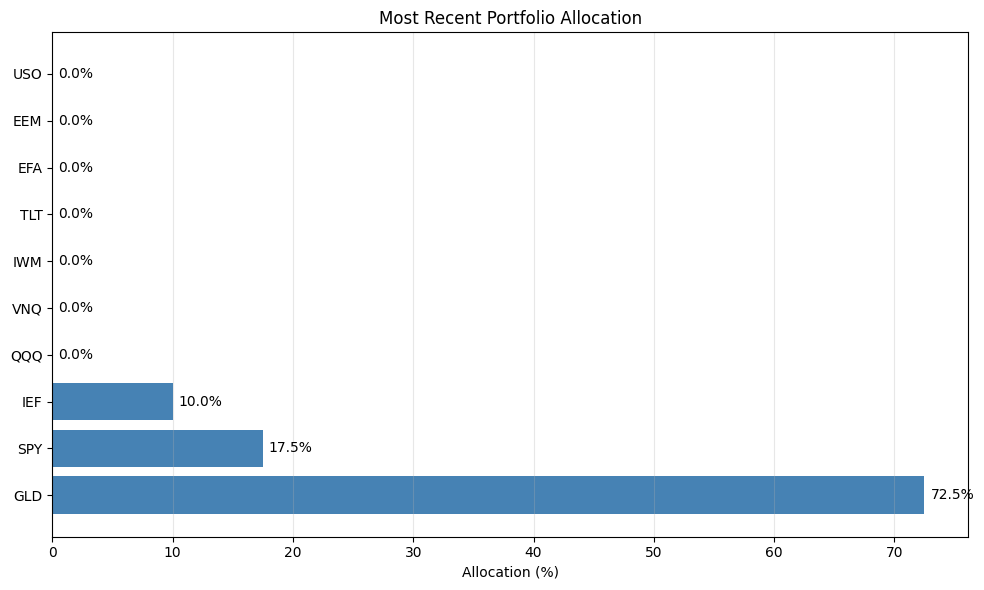


Top 3 holdings: GLD, SPY, IEF


In [61]:
# Display the most recent weight allocation

if len(weights_history) > 0:
    current_weights = weights_history[-1]
    
    current_df = pd.DataFrame({
        'ETF': asset_list,
        'Weight': current_weights,
        'Allocation %': current_weights * 100
    }).sort_values('Weight', ascending=False)
    
    print("Most Recent Portfolio Allocation:")
    print("=" * 50)
    for _, row in current_df.iterrows():
        print(f"{row['ETF']:>4}: {row['Weight']:>8.4f} ({row['Allocation %']:>6.1f}%)")
    
    # Horizontal bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(current_df['ETF'], current_df['Allocation %'], color='steelblue')
    plt.xlabel('Allocation (%)')
    plt.title('Most Recent Portfolio Allocation')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "current_best_allocation.png"), bbox_inches='tight')
    plt.show()
    
    print(f"\nTop 3 holdings: {', '.join(current_df.head(3)['ETF'].tolist())}")
    
else:
    print("No weight history available.")

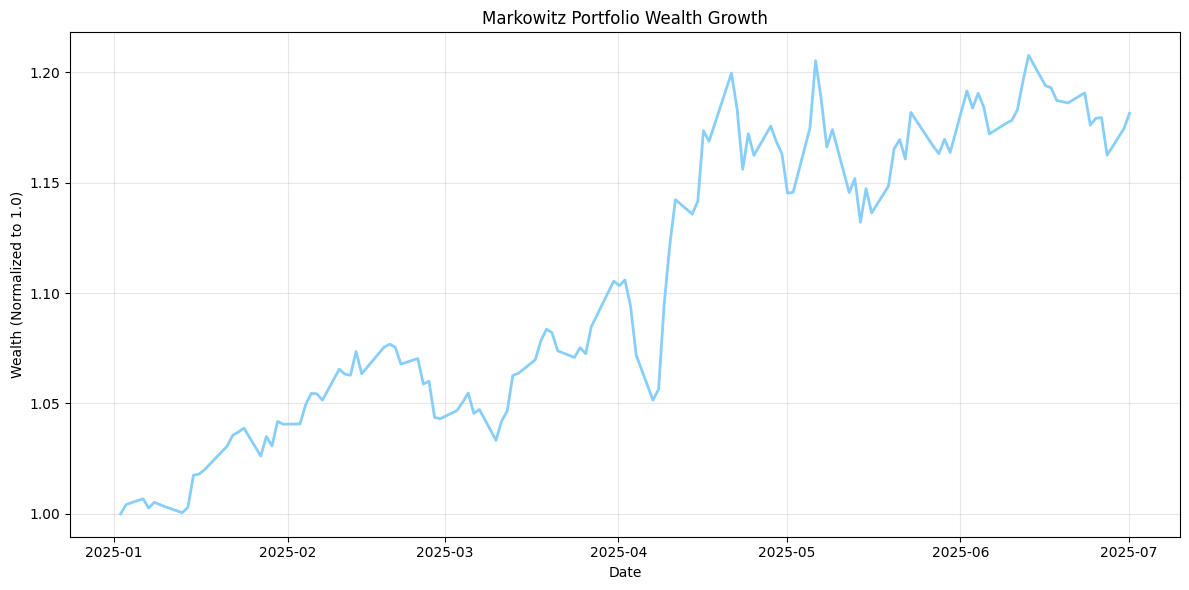

Saved wealth plot to markowitz_outputs\wealth_curve.png


In [62]:
# Plot Markowitz wealth curve (kept in Markowitz notebook)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(wealth_series / wealth_series.iloc[0], linewidth=2, color='lightskyblue')
ax.set_title("Markowitz Portfolio Wealth Growth")
ax.set_xlabel('Date')
ax.set_ylabel('Wealth (Normalized to 1.0)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "wealth_curve.png"), bbox_inches='tight')
plt.show()
print(f"Saved wealth plot to {os.path.join(output_dir, 'wealth_curve.png')}")